In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from discretize_sepsis_actions import discretize_actions

In [108]:
# load data (from DH)
df = pd.read_csv("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/cleansed_data.csv")
df['state_cluster'] = df['state_cluster'].astype('int')
df['action_bin'] = df['action_bin'].astype('int')
# load trajectories (from DH)
trajectories = np.load("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/trajectories.npy")
# load transition_matrix 
transition_matrix = np.load("/Users/linyingzhang/Documents/2017_Fall/CS282/project/data_hw2/transition_matrix.npy")

In [109]:
transition_matrix.shape

(753, 25, 753)

In [112]:
trajectories.shape

(252204, 5)

In [96]:
df.head()

,CO2_mEqL,paCO2,Arterial_pH,sedation,SGPT,bloc,Weight_kg,charttime,rrt,SpO2,...,Chloride,Arterial_BE,state_cluster,input_total_tev,input_4hourly_tev,median_dose_vaso,max_dose_vaso,action_bin,died_in_hosp,mortality_90d
0,-1.393927,-0.850538,-0.367669,-0.651113,0.422769,1,-0.224117,7245052800,-0.266062,-0.207968,...,-0.308782,-1.100552,329,3500.0,2100.0,0.0,0.0,4,0,1
1,-1.393927,-0.850538,-0.367669,-0.651113,0.422769,2,-0.224117,7245067200,-0.266062,-1.359481,...,-0.308782,-1.100552,50,5499.0,1999.0,0.0,0.0,4,0,1
2,-0.940904,-0.740122,-0.293321,-0.651113,0.384762,3,-0.224117,7245081600,-0.266062,-0.160495,...,-0.017808,-0.924161,329,5604.0,105.0,0.0,0.0,2,0,1
3,-0.471104,-0.457906,-0.095059,-0.651113,0.380870,4,-0.224117,7245096000,-0.266062,-0.484716,...,0.011289,-0.453786,490,5664.0,60.0,0.0,0.0,2,0,1
4,-0.323452,-0.877933,0.777290,-0.651113,0.380870,5,-0.224117,7245110400,-0.266062,-0.546156,...,0.011289,-0.108845,532,5724.0,60.0,0.0,0.0,2,0,1


In [67]:
# # Directly taken from DH
# def make_mdp(trajectories, num_states, num_actions):
#     # TODO: fix this hard coding
#     num_terminal_states = 3
#     transition_matrix = np.zeros((num_states + num_terminal_states, num_actions, num_states + num_terminal_states))
#     reward_matrix = np.zeros((num_states + num_terminal_states, num_actions))
#     TRANSITION_PROB_UNVISITED_SAS = 0.0
#     REWARD_UNVISITED_SA = 0.0

#     # create dataframe for easy tallying
#     cols = ['s', 'a', 'r', 'new_s']
#     df = pd.DataFrame(trajectories[:,1:], columns=cols)
#     groups_sas = df.groupby(['s', 'a', 'new_s'])
#     groups_sa = df.groupby(['s', 'a'])
#     avg_reward_sa = groups_sa['r'].mean()
#     transition_count_sa = groups_sa.size()
#     transition_count_sas = groups_sas.size()
    
#     # TODO: vectorize this
#     # but everything is O(1) inside the loop so it's O(n^2m)
#     # TODO: consider mark transition to the imaginary terminal states
#     # to the prob of 1.0. this may be undesirable consequences
#     i = 0
#     print('this is a loop of length', num_states**2 * num_actions)
#     for s in range(num_states):
#         for a in range(num_actions):
#             # handle reward
#             if (s, a) in avg_reward_sa:
#                 reward_matrix[s, a] = avg_reward_sa[(s, a)]
#             else:
#                 reward_matrix[s, a] = REWARD_UNVISITED_SA
#             # handle transitions
#             if (s, a) in transition_count_sa:
#                 num_sa = transition_count_sa[(s, a)]
#                 for new_s in range(num_states):
#                     i+=1
#                     if i % 10000 == 0:
#                         print('i am doing fine, progress:', s, a, new_s)
#                     if (s, a, new_s) in transition_count_sas:
#                         num_sas = transition_count_sas[(s, a, new_s)]
#                         transition_matrix[s, a, new_s] = num_sas / num_sa
#                     else:
#                         transition_matrix[s, a, new_s] = TRANSITION_PROB_UNVISITED_SAS
#             else:
#                 transition_matrix[s, a, :] = TRANSITION_PROB_UNVISITED_SAS

#     return transition_matrix, reward_matrix

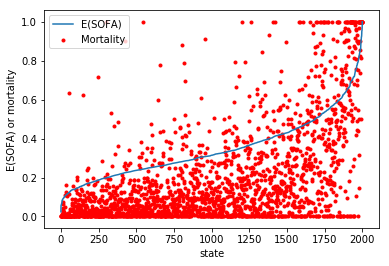

In [26]:
# # calculate the expected SOFA for each state
# def get_Expectation_SOFA(df, states_sequence, state_count):
#     state_E_SOFA = np.zeros((state_count, 1))
#     SOFA_score = df['SOFA']
#     SOFA_count = len(np.unique(SOFA_score))
#     state_SOFA_count_table = np.zeros((state_count, SOFA_count))
#     state_SOFA_matrix = np.zeros(state_SOFA_count_table.shape)

#     for state in range(state_count):
#         ind = np.where(states_sequence == state)[0]
#         state_sofa = SOFA_score[ind]
#         for sofa in state_sofa:
#             state_SOFA_count_table[state, sofa]+=1
#         state_SOFA_matrix[state, :] = state_SOFA_count_table[state, :]/sum(state_SOFA_count_table[state, :])
#         # compute expectation E(SOFA) for each state
#         state_E_SOFA[state,] = sum(state_SOFA_matrix[state, :]*range(SOFA_count))
#     return state_E_SOFA

# def get_state_mortality(df, states_sequence, state_count):    
#     outcome = df['died_in_hosp']
#     state_mortality = np.zeros((state_count, 1))
#     for state in range(state_count):
#         ind = np.where(states_sequence == state)[0]
#         state_death = outcome[ind]
#         state_mortality[state,] = float(sum(state_death))/len(state_death)
#     return state_mortality

# state_E_SOFA = get_Expectation_SOFA(df, states_sequence, state_count)
# state_mortality = get_state_mortality(df, states_sequence, state_count)
# # plot E(SOFA) and mortality for each state
# sorted_state_E_SOFA = np.sort(state_E_SOFA[:, 0])/max(state_E_SOFA[:, 0])
# ind_sorted = np.argsort(state_E_SOFA[:, 0])
# sorted_state_mortality = state_mortality[ind_sorted]
# plt.plot(sorted_state_E_SOFA, label = "E(SOFA)")
# plt.scatter(range(state_count), sorted_state_mortality, marker = ".", color = "red", label = "Mortality")
# plt.xlabel("state")
# plt.ylabel("E(SOFA) or mortality")
# plt.legend(loc = 'best')
# plt.show()

### Conclusion: Some sort of association of SOFA and mortality state-wise. 

In [32]:
def get_physician_policy_mode(states_sequence, actions_sequence, state_count, action_count):
    # S x A count table
    sa_count_table = np.zeros((state_count, action_count))
    physician_policy = np.zeros((state_count))
    for state in range(state_count):
        ind = np.where(states_sequence == state)[0]
        for action in range(action_count):
            sa_count_table[state, action] += sum(actions_sequence[ind] == action)
        physician_policy[state] = np.argmax(sa_count_table[state,:]) # when tie, smallest index returned
    return physician_policy

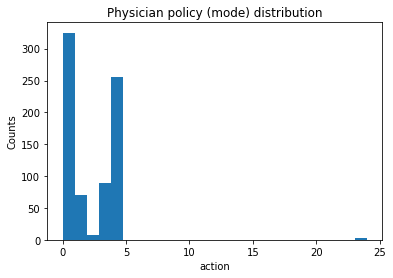

In [115]:
# plot physician's policy
states_sequence = df['state_cluster'].values
actions_sequence = df['action_bin'].values
state_count = 750
action_count = 25
physician_policy = get_physician_policy_mode(states_sequence, actions_sequence, state_count, action_count)
# plot physician's policy
plt.hist(physician_policy,bins=25)
plt.title("Physician policy (mode) distribution")
plt.xlabel("action")
plt.ylabel("Counts")
plt.show()
# Different distribution pattern than my action sequences?????

In [127]:
# columns that are binary:
def find_binary_columns(df):
    variables_to_use = []
    for i in range(df.shape[1]):
        if len(df.iloc[:,i].unique())==2:
            variables_to_use.append(i)
    #exclude last two columns: died_in_hosp and mortality_90d
    variables_to_use = variables_to_use[:-2]
    return variables_to_use
variables_to_use = find_binary_columns(df)
# display binary columns
df.iloc[:5,variables_to_use]

,sedation,rrt,mechvent,re_admission,gender
0,-0.651113,-0.266062,-0.891675,0,0
1,-0.651113,-0.266062,-0.891675,0,0
2,-0.651113,-0.266062,-0.891675,0,0
3,-0.651113,-0.266062,-0.891675,0,0
4,-0.651113,-0.266062,-0.891675,0,0


# IRL

In [138]:
# state basis function
def phi(centroid, state, variables_to_use):
    phi_st = centroid[state, variables_to_use]
    return phi_st

# sampling heuristic trajectories
def sampling_trajectories(transition_matrix, policy, m, state_count):
    absorption_states = [state_count, state_count+1, state_count+2]
    
    keys = range(m)
    sample_trajectories = dict.fromkeys(keys, None)
    
    for i in keys:
        sample_trajectories[i] = []
        #start from a random state
        state = int(np.random.choice(range(state_count)))
        sample_trajectories[i].append(state)
        while state not in absorption_states:
            action = int(policy[state])
            probs = transition_matrix[state,action,:]
            next_state = int(np.random.choice(np.arange(state_count+len(absorption_states)), p=probs))
            sample_trajectories[i].append(next_state)
            state = np.copy(next_state)
    return sample_trajectories
    
# function to calculate mu
def feature_expectation(sample_trajectories, gamma):
    mu = np.zeros((variable_count))
    
    # loop over all trajectories
    for i in range(m):
        trajectory = sample_trajectories[i]
        # loop over all states in that trajectory
        t = 0
        for state in trajectory:
            phi_st = phi(centroid, state, variables_to_use)
            mu += gamma**t*phi_st
            t+=1
    mu = 1/float(m)*mu    
    return mu

def reward(w, centroid, variables_to_use):
    R = w*centroid[:, variables_to_use]
    return R

In [141]:
gamma = 0.95
action_count = 25
state_count = 750

variables_to_use = find_binary_columns(df)
variable_count = len(variables_to_use)

# initialize w
w = np.zeros((variable_count))
# initialize policy pi
pi = np.zeros((state_count))
# make some random centroid matrix
centroid = np.ones((state_count, df.shape[1]))

R = reward(w, centroid, variables_to_use)

# sample trajectories
m=100
sample_trajectories = sampling_trajectories(transition_matrix, pi, m, state_count)
mu = feature_expectation(sample_trajectories, gamma)

ValueError: probabilities do not sum to 1

In [1]:
## PROBLEM ##: transition_matrix[state, action, :] NOT SUM TO 1 !!!

for state in range(state_count):
    for action in range(action_count):
        if sum(transition_matrix[state, action, :])!=1:
            if sum(transition_matrix[state, action, :])!=0:
                print (state, action)

NameError: name 'state_count' is not defined